In [1]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatibl

# Поиск по изображениям

**Цель работы:** разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

<a id='id_1'></a>
### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Обзор и исследовательский анализ данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
import re
import torch
import pickle
import tensorflow as tf
import keras_nlp
import sentence_transformers
import glob

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, minmax_scale
from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# загрузка датасета

!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

In [5]:
data_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [6]:
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...  
8  A young child is wearing blue goggles and sitt...  
9  A young child is wearing blue goggles and sitt...

In [7]:
for i in data_train.columns:
    print(i, data_train[i].nunique())

image 1000
query_id 977
query_text 977


Обучающий датасет состоит из 5822-х строк, пропуски отсутствуют, при этом уникальных изображений всего 1000, а запросов - 977. Описание столбцов приведено в [описании данных](#id_1).

In [8]:
data_test = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), index_col=[0], sep='|')

In [9]:
data_test.info()
data_test.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   
8  1232148178_4f45cc3284.jpg#3   
9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [10]:
for i in data_test.columns:
    print(i, data_test[i].nunique())

query_id 500
query_text 500
image 100


Имеем 500 тестовых запросов, пропуски отсутствуют, при этом уникальных изображений всего 100. Описание столбцов приведено в [описании данных](#id_1).

Посмотрим на представленные изображения.

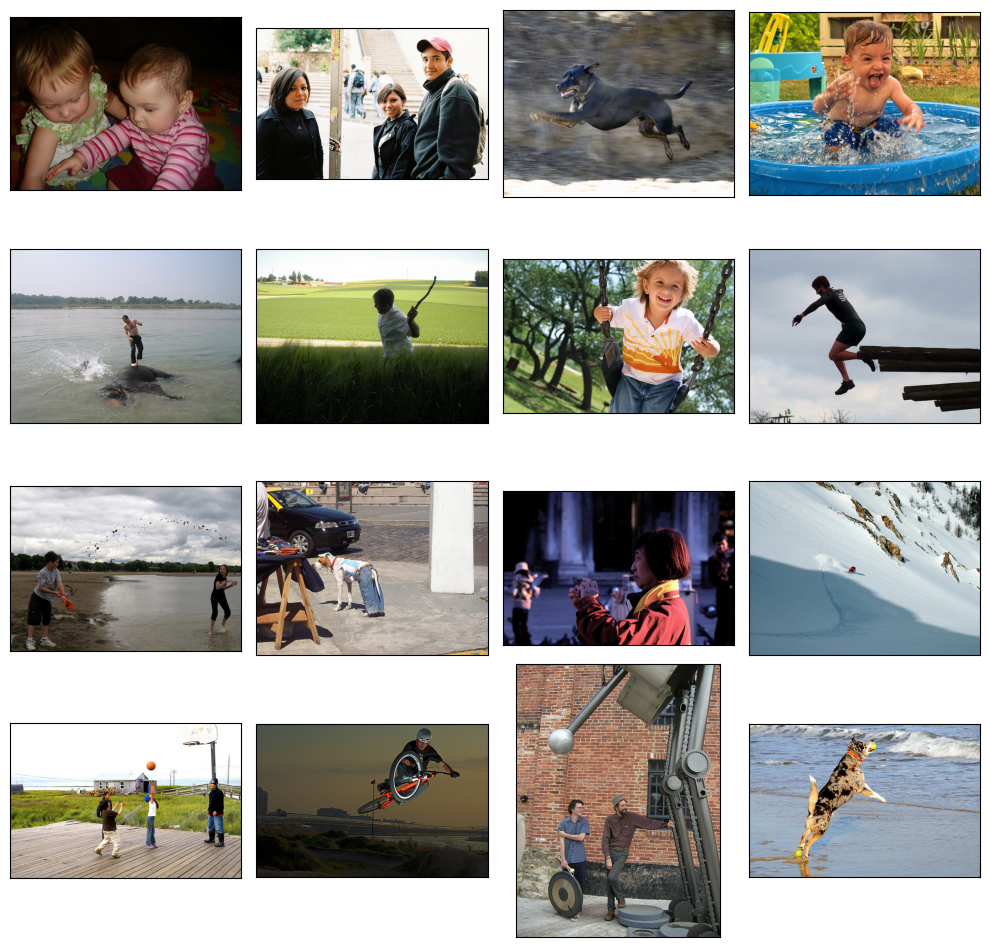

In [11]:
samples_train = list(data_train['image'].sample(8))
samples_test = list(data_test['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(os.path.join(DATA_PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(os.path.join(DATA_PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Представлено большое разнообразие изображений, в том числе и попадающие под юридические ограничения в некоторых странах.

In [12]:
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))

In [13]:
# функция для чтения файлов .tsv
def read_tsv(data_name):
    data = pd.read_csv(os.path.join(DATA_PATH, data_name), sep='\t', names = ['image', 'query_id', 'one', 'two', 'three'])
    return data

In [14]:
data_crowd = read_tsv('CrowdAnnotations.tsv')
data_crowd.info()
data_crowd.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   one       47830 non-null  float64
 3   two       47830 non-null  int64  
 4   three     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


image                     query_id       one  two  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.000000    3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.000000    0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.000000    0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.000000    0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.000000    0   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2  0.000000    0   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2  0.000000    0   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2  0.333333    1   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2  0.000000    0   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2  0.000000    0   

   three  
0      0  
1      3  
2      3  
3      3  
4      3  
5      3  
6      3  
7      2  
8      3  
9      3

Краудсорсинговый датасет состоит из 47830-ти строк, пропуски отсутствуют. Описание столбцов приведено в [описании данных](#id_1).

In [15]:
data_crowd['one'].value_counts().to_frame().style.background_gradient('Reds')

Видим, что в данных преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю.На таких данных модель, вероятно, обучится плохо. Поэтому будем использовать только мнения экспертов, во-первых, потому что их профессиональное мнение само по себе несет бОльшую ценность, во-вторых, потому что набор данных имеет шкалу соответствия картинки и текста, что может помочь при обучении модели.

In [17]:
data_expert = read_tsv('ExpertAnnotations.tsv')
data_expert.info()
data_expert.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   one       5822 non-null   int64 
 3   two       5822 non-null   int64 
 4   three     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


image                     query_id  one  two  three
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    1    1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    1    1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    1    1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    1    2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    1    1      2
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2    1    1      1
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2    1    1      1
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2    1    1      2
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2    1    1      1
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2    2    2      2

Экспертный датасет состоит из 5822-х строк, пропуски отсутствуют. Описание столбцов приведено в [описании данных](#id_1).

Обработаем оценки экспертов. Если все три числа разные, то возьмем среднее значение округленное до целого числа, иначе - выберем голосованием по большинству. Сразу выполним преобразование к диапазону от 0 до 1.

In [18]:
def expert_agg(row):
    if row['one'] != row['two'] != row['three']:
        row['score'] = int(row['one'] + row['two'] + row['three']) / 3 / 3
    else:
        row['score'] = (int(pd.Series([row['one'], row['two'], row['three']]).mode()) - 1) / 3
    return row

In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)
data_expert = data_expert.apply(expert_agg, axis=1)

Столбец `score` в диапазоне от 0 до 1 теперь является целевым для нашего набора данных. Добавим его в тренировочный датафрейм.

In [25]:
data_train = pd.merge(data_train, data_expert[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [26]:
data_train.info()
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   score       5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.333333  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.000000

**Вывод по первому шагу:** выполнили обзор представленных данных, обнаружили, что на 5000 тренировочных изображений приходится 1000 уникальных, на 500 тестовых - 100 уникальных. Данные с изображениями отличаются большим разнообразием в том числе присутствуют изображения, попадающие под юридические ограничения в некоторых странах.

Рассмотрели разметку данных выполненную краудфайндерами и экспертами. В данных крауда преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю. На таких данных модель, вероятно, обучится плохо. Поэтому будем использовать только мнения экспертов, во-первых, потому что их профессиональное мнение само по себе несет бОльшую ценность, во-вторых, потому что набор данных имеет шкалу соответствия картинки и текста, что может помочь при обучении модели. Поэтому трансформировали оценку трех экспертов в одну агрегированную оценку и добавили её к тренировочному датафрейму.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим список слов, которые могут попадать под юридические ограничения.

In [29]:
law_stopwords = [
    "child",
    "children",
    "kid",
    "kids",
    "baby",
    "babies",
    "boy",
    "boys",
    "girl",
    "girls",
    "teen",
    "teens",
    "teenage",
    "teenager",
    "teenagers",
    "infant",
    "infants",
    "youngster",
    "youngsters",
]

Получим список фотографий, которые находятся под запретом в некоторых странах.

In [33]:
def get_bad_id(row):
    for word in row['query_text'].split(' '):
        if (word in law_stopwords):
            row['bad_id'] = row['query_id'][:-2]
            break
    return row

In [34]:
data_train = data_train.apply(get_bad_id, axis=1)
bad_id_list = data_train['bad_id'].to_list()
cleaned_bad_id_list = [x for x in bad_id_list if str(x) != 'nan']

Посмотрим, как наша разметка справилась с задачей.

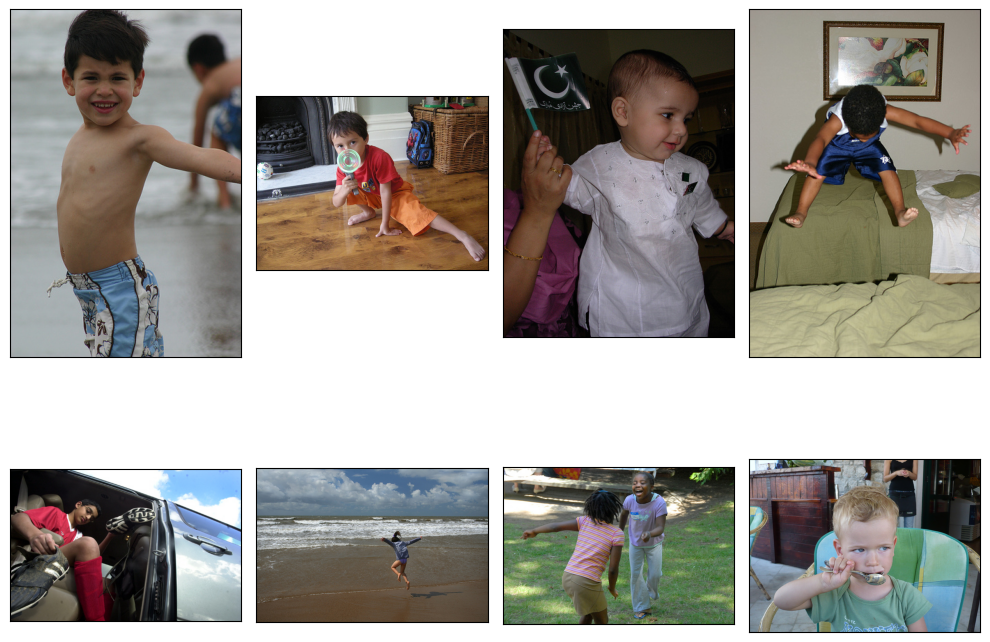

In [35]:
samples_train = np.unique(cleaned_bad_id_list)[:8]

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    image = Image.open(os.path.join(DATA_PATH, 'train_images/', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видим, что разметка неплохо справилась со  своей задачей, определив детей на фотографиях. Далее удалим строки, где названия изображений совпадают с названиями запрещенных изображений. Сама колонка с запрещенными изображениями нам тоже не нужна.

In [36]:
def drop_bad_img(row):
    if row['image'] in cleaned_bad_id_list:
        row = row.drop('image', axis=0, inplace=True)
    return row

In [37]:
data_train = data_train.apply(drop_bad_img, axis=1)

In [38]:
data_train = data_train.drop('bad_id', axis=1)
data_train = data_train.dropna().reset_index(drop=True)

In [40]:
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4204 entries, 0 to 4203
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4204 non-null   object 
 1   query_id    4204 non-null   object 
 2   query_text  4204 non-null   object 
 3   score       4204 non-null   float64
dtypes: float64(1), object(3)
memory usage: 131.5+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
3  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
4  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
5   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
6  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
7   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
8  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
9  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.000000  
3  A young child is wearing blue goggles and sitt...  0.000000  
4  A young child is wearing blue goggles and sitt...  0.000000  
5  A young child is wearing blue goggles and sitt...  0.000000  
6  A young child is wearing blue goggles and sitt...  0.000000  
7  A young child is wearing blue goggles and sitt...  0.000000  
8  A girl wearing a yellow shirt and sunglasses s...  0.000000  
9  A girl wearing a yellow shirt and sunglasses s...  0.333333

**Вывод по второму шагу:** задали список слов, которые могут попадать под юридические ограничения. Создали алгоритм, который позволил отфильтровать запросы с запретными словами. Тем самым сформировали окончательный набор тренировочных данных, состоящий из 4204-х строк.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Напишем функцию для загрузки изображений.

In [41]:
def load_train(path):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data_train,
        directory=path,
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        shuffle=False,
        seed=99)

    return train_gen_flow

In [42]:
path = os.path.join(DATA_PATH, 'train_images')
features, target = next(load_train(path))

Found 4204 validated image filenames.


Загрузчик нашел 4204 валидированных названий изображений.

Рассмотрим размерность признаков.

In [43]:
features.shape

(16, 224, 224, 3)

Получились признаки — четырёхмерный тензор, в котором 16 изображений размером 224x224 с тремя цветовыми каналами.

Далее напишем функцию для модели. Т.к. у нас стоит задача только векторизовать изображения, последний, предсказывающий, слой `Dense` исключим.

In [45]:
def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    optimizer = Adam(learning_rate = 0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

После чего напишем функцию для превращения картинок в вектор и выполним ее.

In [46]:
def vectorize_pic(model, data_train):
    preds = model.predict(data_train)
    return preds

In [47]:
vec_pics = vectorize_pic(create_model(), load_train(path))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 4204 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step


In [48]:
vec_pics.shape

(4204, 2048)

Получили двумерный массив размером 4204 на 2048.

**Вывод по третьему шагу:** выполнили векторизацию изображений средствами библиотеки `Keras`. На выходе получили двумерный массив размером 4204 на 2048. Далее можем перейти к векторизации текстов.

## 4. Векторизация текстов


Для текстов воспользуемся предобученным англоязычным берт-трансформером. Инициализируем предтренированные токенизатор и модель

In [49]:
tokenizer = keras_nlp.models.BertBackbone.from_preset('bert_base_en')
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

100%|██████████| 510/510 [00:00<00:00, 529kB/s]
100%|██████████| 414M/414M [00:23<00:00, 18.7MB/s]
100%|██████████| 548/548 [00:00<00:00, 446kB/s]
100%|██████████| 208k/208k [00:00<00:00, 333kB/s]


После чего закодируем наш текст с помощью токенизатора,  приведем длину текстов в корпусе к единой(максимальной из всех имеющихся в наборе) длине.

In [50]:
def vectorize_text(model, data, batch_size, preprocessor=preprocessor, bar=True, verbose=0):
    tokenized = preprocessor(data)

    embeddings = []
    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])
    return np.concatenate(embeddings)

In [51]:
features_text = vectorize_text(model=tokenizer, data=data_train['query_text'], batch_size=4)

  0%|          | 0/1051 [00:00<?, ?it/s]

In [52]:
features_text.shape

(4204, 768)

Получили двумерный массив размером 4204 на 768.



**Вывод по четвертому шагу:** выполнили векторизацию текстовых запросов при помощи трансформера `Bert`. На выходе получили двумерный массив размером 4204 на 768. Теперь перейдем к объединению получившихся векторов.

## 5. Объединение векторов

Объединим векторы изображений и векторы текстов.

In [53]:
X = np.concatenate((vec_pics, features_text), axis=1)

Зададим целевой признак.

In [54]:
y = np.array(data_train['score'])

Посмотрим размерности получившихся наборов признаков.

In [55]:
X.shape, y.shape

((4204, 2816), (4204,))

Сохраним результаты получившихся фичей и таргета для последующей быстрой загрузки.

In [56]:
save_path = '/content/drive/MyDrive/datasets'


os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, 'X.pickle'), 'wb') as f:
    pickle.dump(X, f)

with open(os.path.join(save_path, 'y.pickle'), 'wb') as f:
    pickle.dump(y, f)

print(f"Файлы сохранены в {save_path}")

Файлы сохранены в /content/drive/MyDrive/datasets


In [57]:
# Код для загрузки сохраненных данных
'''
load_path = '/content/drive/MyDrive/datasets'


with open(os.path.join(load_path, 'X.pickle'), 'rb') as f:
    X = pickle.load(f)

with open(os.path.join(load_path, 'y.pickle'), 'rb') as f:
    y = pickle.load(f)

print("Данные успешно загружены")
print(X.shape, y.shape)
'''

Данные успешно загружены
(4204, 2816) (4204,)


**Вывод по пятому шагу:** выполнили объединение векторов текстовых запросов и изображений. Для фичей получили двумерный массив размером 4204 на 2816, для таргета - вектор длиной 4204.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и валидационную выборки в пропорции 8:2 так, что строки с одинаковым значением 'group_column' будут содержаться либо в валидационном, либо в тренировочном датасете.

In [58]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=99)
train_indices, valid_indices = next(gss.split(
    X=X,
    y=y,
    groups=data_train['image']))
X_train, X_valid = X[train_indices], X[valid_indices]
y_train, y_valid = y[train_indices], y[valid_indices]

In [59]:
X_train.min(), X_train.max(), X_train.mean()

(-1.0, 31.725136, 0.4111979)

Данные необходимо отмасштабировать.

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

В качестве линейной модели используем линейную регрессию с L2 регуляризацией - Ridge.

Т.к. перед нами стоит задача регрессии, за метрику примем `RMSE`.

In [61]:
linear_model = Ridge(alpha=500)

In [64]:
linear_model.fit(X_train, y_train)

Ridge(alpha=500)

Посмотрим, как модель покажет себя на валидационных данных.

In [66]:
preds = linear_model.predict(X_valid)
(mean_squared_error(y_valid, preds) ** 0.5).round(decimals=3)

0.312

Далее рассмотрим нейронную сеть.

In [67]:
nn = Sequential()
nn.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='tanh'))
nn.add(BatchNormalization())
nn.add(Dropout(0.3))
nn.add(Dense(512, activation='tanh'))
nn.add(BatchNormalization())
nn.add(Dropout(0.2))
nn.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.0001)

nn.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

nn.build()

nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2816)                │       7,932,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2816)                │          11,264 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,442,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,388,801 (35.82 MB)

 Trainable params: 9,382,145 (35.79 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [68]:
nn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256, epochs=1000,
    verbose=2, shuffle=True
    )

Epoch 1/1000
14/14 - 10s - 703ms/step - loss: 0.5974 - root_mean_squared_error: 0.9480 - val_loss: 0.3235 - val_root_mean_squared_error: 0.4659
Epoch 2/1000
14/14 - 6s - 419ms/step - loss: 0.5358 - root_mean_squared_error: 0.8463 - val_loss: 0.2800 - val_root_mean_squared_error: 0.4262
Epoch 3/1000
14/14 - 9s - 615ms/step - loss: 0.4728 - root_mean_squared_error: 0.7572 - val_loss: 0.3174 - val_root_mean_squared_error: 0.4405
Epoch 4/1000
14/14 - 6s - 462ms/step - loss: 0.4464 - root_mean_squared_error: 0.7193 - val_loss: 0.2667 - val_root_mean_squared_error: 0.4019
Epoch 5/1000
14/14 - 9s - 654ms/step - loss: 0.4157 - root_mean_squared_error: 0.6666 - val_loss: 0.2677 - val_root_mean_squared_error: 0.4019
Epoch 6/1000
14/14 - 6s - 435ms/step - loss: 0.3892 - root_mean_squared_error: 0.6138 - val_loss: 0.2570 - val_root_mean_squared_error: 0.4050
Epoch 7/1000
14/14 - 8s - 596ms/step - loss: 0.3622 - root_mean_squared_error: 0.5771 - val_loss: 0.2649 - val_root_mean_squared_error: 0.412

Модель линейной регресси и нейронная сеть показали примерно одинаковые результаты. Для тестирования выберем модель нейронной сети, т.к. её результат всё же несколько лучше.

**Вывод по четвертому шагу:** разделили данные на обучающие и тестовые, провели обучение и тестирование двух моделей: линейной регрессии и нейронной сети, которые показали примерно одинаковые результаты. Для тестирования выберем модель неросети, с `RMSE` на валидационной выборке равным 0,285.

## 7. Тестирование модели

Настало время протестировать модель. Напишем функцию для загрузки тестовых данных.

In [69]:
def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=data_test,
        directory=path,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        shuffle=False,
        seed=99)

    return test_gen_flow

Получим эмбеддинги для всех тестовых изображений из папки `test_images`.

In [70]:
path_test = os.path.join(DATA_PATH, 'test_images')
test_pics_embeds = vectorize_pic(create_model(), load_test(path_test))

Found 500 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step


Выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Все это сделаем в виде функции.

In [80]:
def image_by_query(query):
    if [i for i in query.split(' ') if i in law_stopwords]:
        print()
        print('*' * 20, query, '*' * 20)
        print()
        print('!' * 15, 'This image is unavailable in your country in compliance with local laws.', '!' * 15)
        print()
    else:
        features_text = vectorize_text(model=tokenizer, data=[query], bar=False, batch_size=1)
        embed_text = np.resize(features_text, (test_pics_embeds.shape[0], 768))
        X = np.concatenate((test_pics_embeds, embed_text), axis=1)
        preds = nn.predict(X)
        image_preds = pd.concat(
            (test_images,
             pd.Series(data=[query for i in range(len(test_images))], name='query'),
             pd.Series(data=preds.flatten(), name='preds')), axis=1).dropna()
        top = list(image_preds.sort_values(by='preds', ascending=False)['image'].head(1))
        top_score = list(image_preds.sort_values(by='preds', ascending=False)['preds'].head(1))

        print()
        print('*' * 15, query, '*' * 15)
        print()

        fig = plt.figure(figsize=(10,3))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0

        fig.add_subplot(1, 2, 1, title=round(*top_score, 2))
        image = Image.open(os.path.join(DATA_PATH, "test_images", *top))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

        fig = plt.figure(figsize=(2,2))
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        image = Image.open(
            os.path.join(DATA_PATH, "test_images",
            data_test.iloc[data_test[data_test["query_text"] == query].index[0]]['image'])
            )
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        print()

        plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

*************** a large group of young people all dressed in white tops and green bottoms ***************



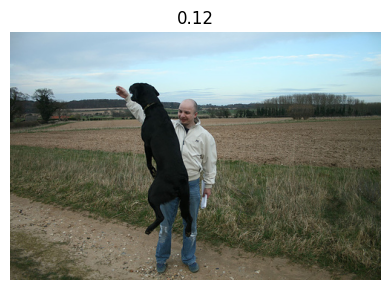

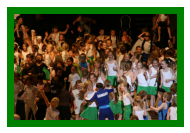

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

*************** a large man dozes off on the bus . ***************



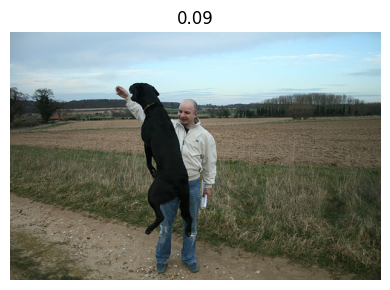

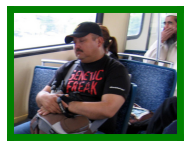

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

*************** a little white and tan dog running through the grass with a stick in his mouth . ***************



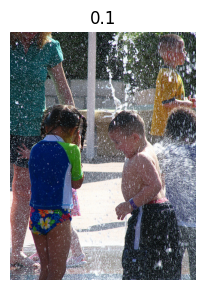

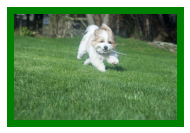


******************** The boy jumps into the water off of a dock . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

*************** A caramel colored dog sits in front of trees looking forward . ***************



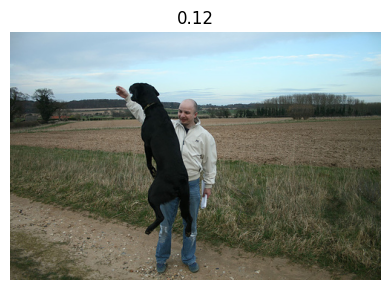

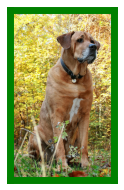

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

*************** At the bottom of a set of stairs , there are two men and a tent . ***************



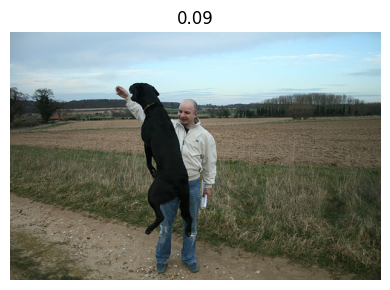

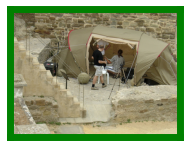

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

*************** Woman in white bikini top and blue shorts with body of water in the background . ***************



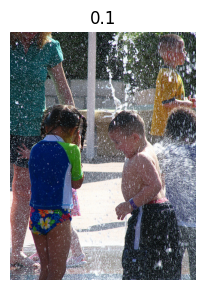

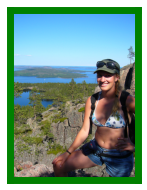


******************** A boy walks across a rope structure on a playground . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

*************** Two dogs stand in the brown grass . ***************



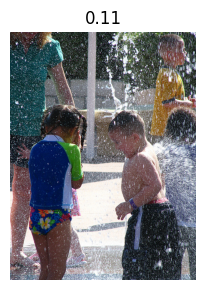

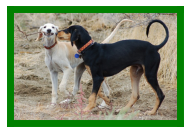


******************** A boy holds a red bucket up to a pony . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!



In [81]:
test_sample = data_test.sample(10)
text_test = list(test_sample['query_text'])
for query in text_test:
    image_by_query(query)

**Вывод по седьмому шагу:** написали функцию, которая выводит фото с лучшим предсказанием и действительное изображение по описанию. Визуально оценили работу модели. Качество её работы неудовлетварительно, т.к. предсказанное изображение имеет мало чего общего с действительным изображением.

## 8. Общий вывод

Выполнили обзор представленных данных, обнаружили, что на 5000 тренировочных изображений приходится 1000 уникальных, на 500 тестовых - 100 уникальных. Данные с изображениями отличаются большим разнообразием в том числе присутствуют изображения, попадающие под юридические ограничения в некоторых странах.

Рассмотрели разметку данных выполненную краудфайндерами и экспертами. В данных крауда преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю. На таких данных модель, вероятно, обучится плохо. Поэтому будем использовать только мнения экспертов, во-первых, потому что их профессиональное мнение само по себе несет бОльшую ценность, во-вторых, потому что набор данных имеет шкалу соответствия картинки и текста, что может помочь при обучении модели. Поэтому трансформировали оценку трех экспертов в одну агрегированную оценку и добавили её к тренировочному датафрейму.

Задали список слов, которые могут попадать под юридические ограничения. Лемматизировали и очистили текстовые запросы. Создали алгоритм, который позволил отфильтровать запросы с запретными словами. Тем самым сформировали окончательный набор тренировочных данных, состоящий из 4204-ех строк.

Далее выполнили векторизацию изображений средствами библиотеки `Keras`. На выходе получили двумерный массив размером 4204 на 2048.

После чего выполнили векторизацию текстовых запросов при помощи трансформера `Bert`. На выходе получили двумерный массив размером 4204 на 768.

Затем выполнили объединение векторов текстовых запросов и изображений. Для фичей получили двумерный массив размером 4204 на 2816, для таргета - вектор длиной 4204.

Разделили данные на обучающие и тестовые, провели обучение и тестирование двух моделей: линейной регрессии с L2 регуляризацией и нейронной сети, которые показали примерно одинаковые результаты. Для тестирования выберем модель неросети, с `RMSE` на валидационной выборке равным 0,288.

Написали функцию, которая выводит фото с лучшим предсказанием и действительное изображение по описанию. Визуально оценили работу модели. Качество её работы неудовлетварительно, т.к. предсказанное изображение имеет мало чего общего с действительным изображением. Вероятно, для решения данной задачи стоит использовать современные нейронные сети, предназначенные именно для поиска изображений по текстовому описанию.

## CLIP

Всё же нам необходимо решить поставленную перед нами задачу. В этом нам поможет уже предобученная нейронная сеть  OpenAI CLIP Model, которая обучена на множестве пар изображение-текст и упакована в библиотеку `sentence-transformers`.

In [82]:
clip_model = SentenceTransformer('clip-ViT-B-32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Создадим список картинок тестового набора и получим для них эмбеддинги.

In [83]:
img_names = list(glob.glob(str(os.path.join(DATA_PATH, 'test_images', '*.jpg'))))
img_emb = clip_model.encode(
    [Image.open(filepath) for filepath in img_names],
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Перепишем нашу функцию поиска под новую модель.

In [84]:
def clip_image_by_query(query):
    if [i for i in query.split(' ') if i in law_stopwords]:
        print()
        print('*' * 20, query, '*' * 20)
        print()
        print('!' * 15, 'This image is unavailable in your country in compliance with local laws.', '!' * 15)
        print()
    else:
        query_emb = clip_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
        hits = util.semantic_search(query_emb, img_emb, top_k=5)[0]

        print()
        print('*' * 15, query, '*' * 15)
        print()

        fig = plt.figure(figsize=(10,3))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(hits[i]['score'], 2))
            image = Image.open(img_names[hits[i]['corpus_id']])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

        fig = plt.figure(figsize=(2,2))
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        image = Image.open(
            os.path.join(DATA_PATH, "test_images",
            data_test.iloc[data_test[data_test["query_text"] == query].index[0]]['image'])
            )
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        print()

        plt.show()


*************** a snowboarder wearing red is descending a snow covered mountain . ***************



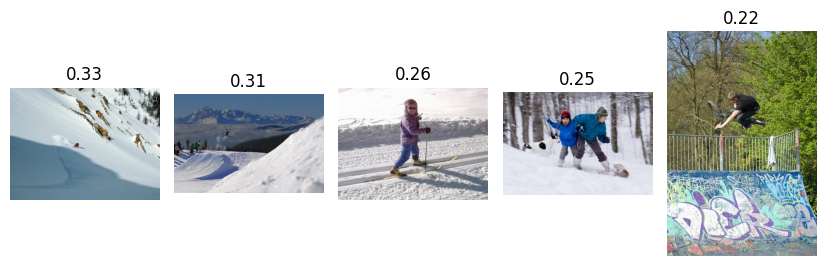

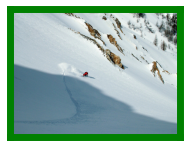


******************** A young girl sits on the forest floor and looks up through binoculars . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!


******************** a boy flings sand at a girl . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!


*************** Three people are looking into photographic equipment . ***************



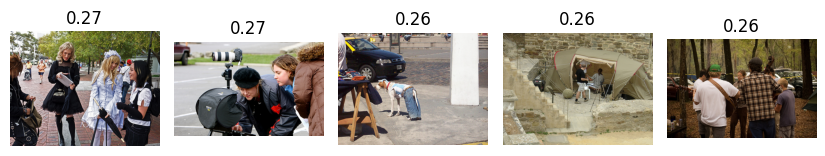

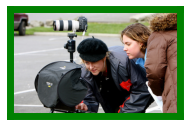


******************** A family watches as a little girl blows out the candles on her third birthday ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!


*************** A woman with glasses is sewing . ***************



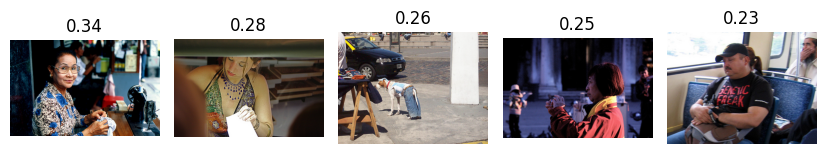

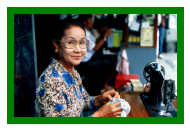


******************** Two girls walking next to each other and talking . ********************

!!!!!!!!!!!!!!! This image is unavailable in your country in compliance with local laws. !!!!!!!!!!!!!!!


*************** A group of people are in the woods playing instruments . ***************



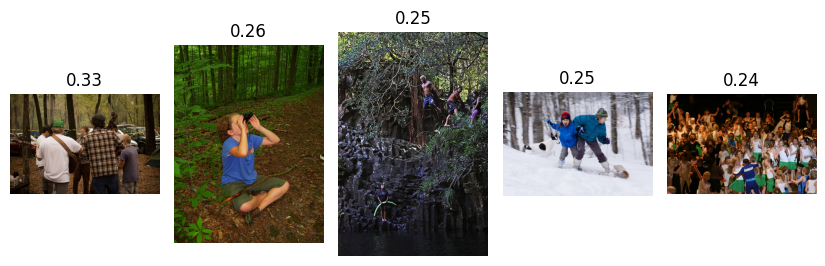

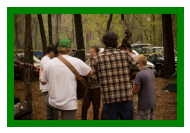


*************** A large gray bird begins to land in the water . ***************



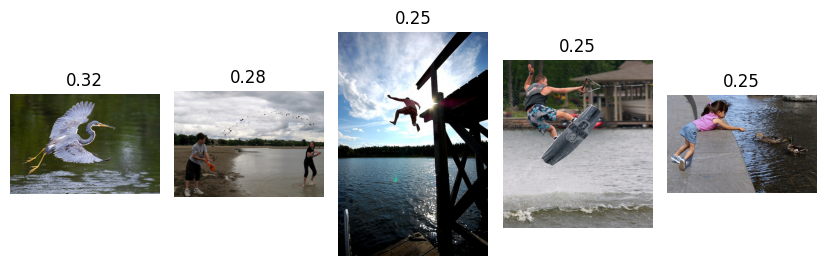

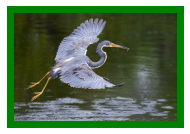


*************** A blue bird flying over water . ***************



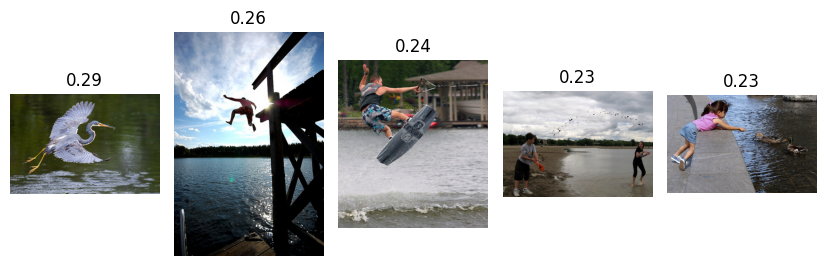

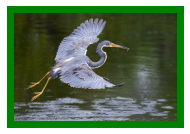

In [85]:
clip_test_sample = data_test.sample(10)
clip_text_test = list(clip_test_sample['query_text'])
for query in clip_text_test:
    clip_image_by_query(query)

Видим, что данный подход себя оправдал. Модель отлично справляется с поиском изображений по запросу.